In [ ]:
from pathlib import Path
import os
import re
import html
import string

import unicodedata

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df=pd.read_csv(r"/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv",names=["Borderlands","Positive","sentement"])


In [5]:
df.head()

,Borderlands,Positive,sentement
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df.shape

(74682, 3)

In [7]:
df.isnull().sum()

Borderlands      0
Positive         0
sentement      686
dtype: int64

In [8]:
classes = df['Positive'].unique()
classes

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [9]:
n_classes = df['Positive'].nunique()
n_classes

4

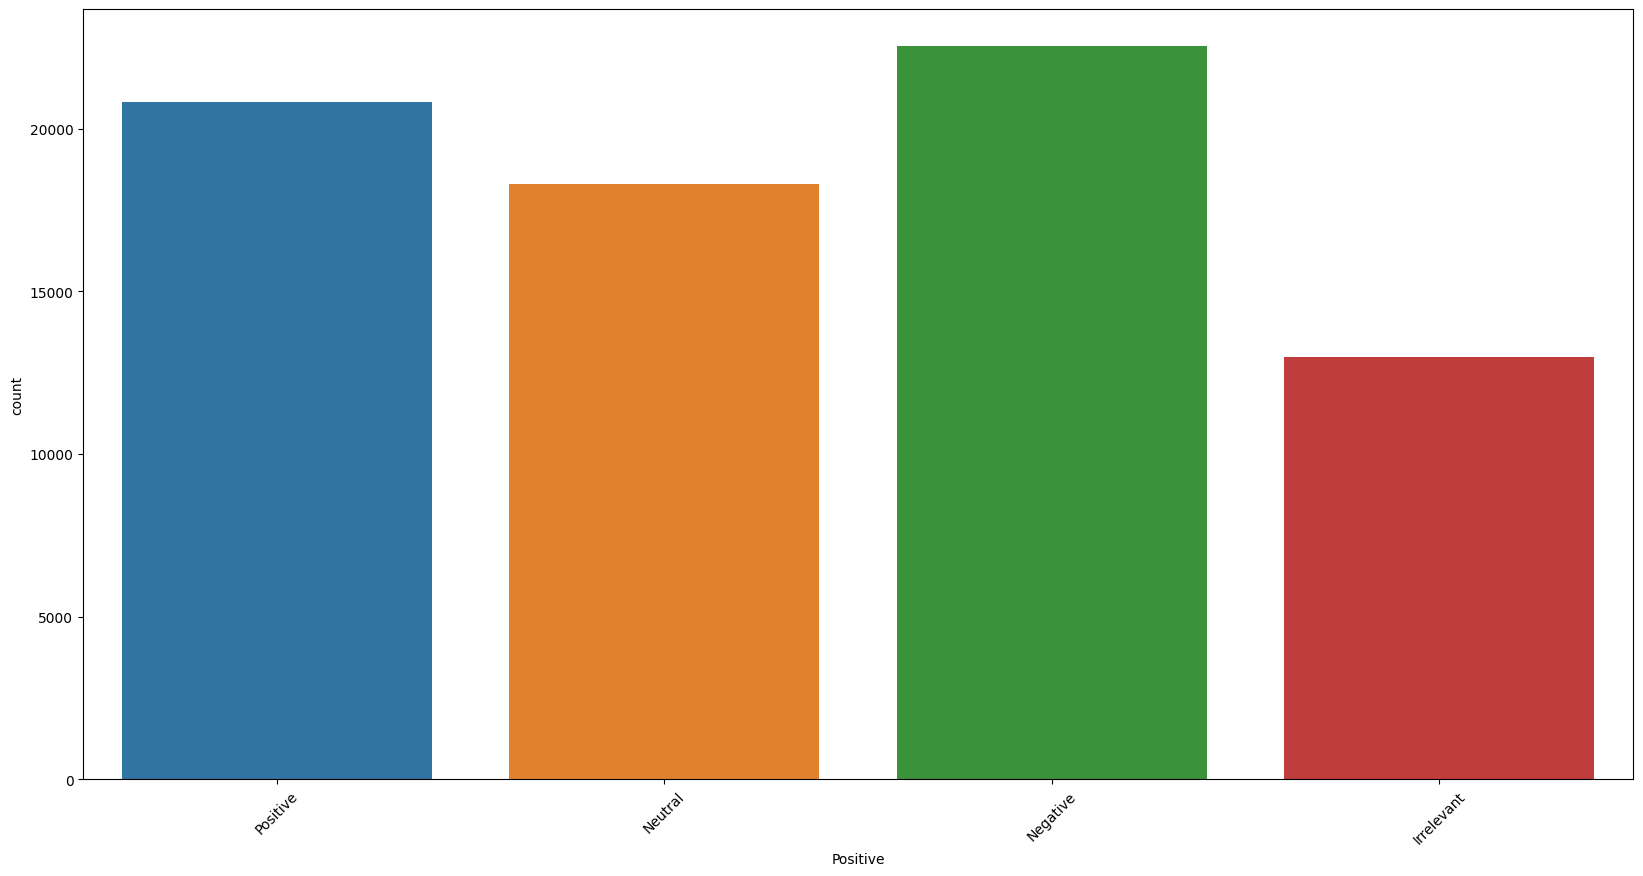

In [10]:
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='Positive')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def remove_non_ascii(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):

    return [word for word in words if word not in stop_words]


def stem_words(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  return word_tokenize(text)

def normalize_text(text):
    if not isinstance(text, str):
        text = ''  
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    stop_words = stopwords.words('english')
    words = remove_stopwords(words, stop_words)
    return ' '.join(words)


    return ' '.join(words)

In [40]:
def normalize_corpus(corpus):
  return [normalize_text(t) for t in corpus]

In [41]:
df['sentement'] = normalize_corpus(df['sentement'])

In [42]:
df['sentement'].head()

2401    im getting borderlands murder
2401              coming borders kill
2401      im getting borderlands kill
2401     im coming borderlands murder
2401    im getting borderlands murder
Name: sentement, dtype: object

In [ ]:
from collections import Counter

sequences = [desc.split() for desc in df['sentement']]

sequence_lengths = [len(seq) for seq in sequences]

length_counts = Counter(sequence_lengths)

lengths = list(length_counts.keys())
counts = list(length_counts.values())

In [44]:
length_counts.most_common(5)

[(6, 4740), (5, 4512), (4, 4478), (8, 4368), (3, 4341)]

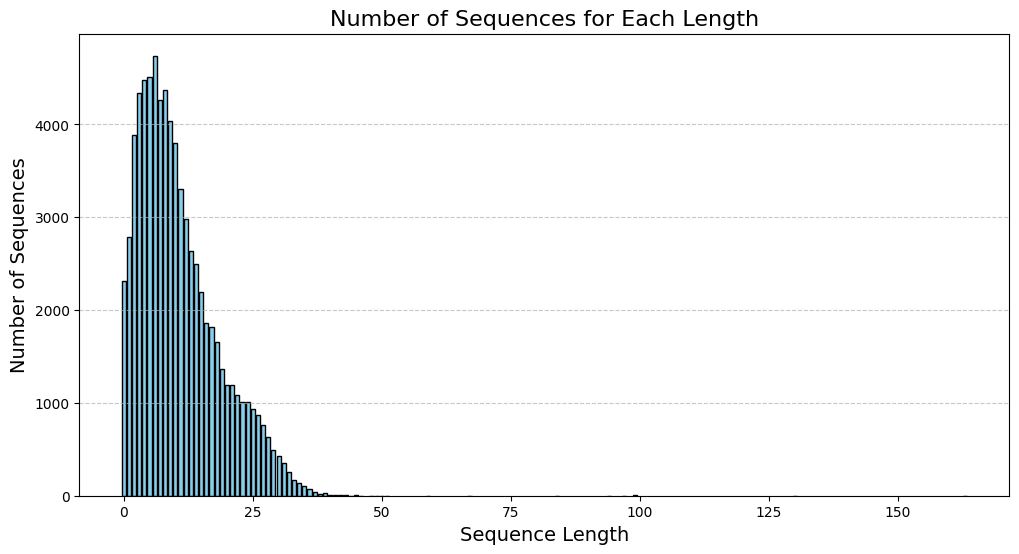

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(lengths, counts, color='skyblue', edgecolor='black')
plt.title('Number of Sequences for Each Length', fontsize=16)
plt.xlabel('Sequence Length', fontsize=14)
plt.ylabel('Number of Sequences', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [46]:
vocab_sz = 100000
tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(df['sentement'])

In [47]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train,y_test = train_test_split(df['sentement'],df['Positive'],test_size=0.2,random_state=42)

In [48]:
# Convert texts to sequences
x_train_seq = tok.texts_to_sequences(x_train)
x_test_seq = tok.texts_to_sequences(x_test)

In [49]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [50]:
classes_lb = lb.classes_
classes_lb

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [51]:
def get_max_len(texts):
  return max([len(word_tokenize(text)) for text in texts])

In [52]:
#maxlen = get_max_len(df['Description'])
maxlen = 100

In [53]:
# Pad sequences to the same length
x_train = pad_sequences(x_train_seq, maxlen=maxlen, padding='post', truncating='post')  # Adjust `maxlen` as needed
x_test = pad_sequences(x_test_seq, maxlen=maxlen, padding='post', truncating='post')


In [54]:
print("First padded training sequence:", x_train[0])
print("First padded testing sequence:", x_test[0])

First padded training sequence: [3680 9694  469 1757 1774 7718  160  759 3888    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
First padded testing sequence: [ 209  528  112    3   81  706 1119   32  662   72    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.layers import Embedding
from keras.layers import SimpleRNN

embedding_size = 100

model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  
model.add(Dropout(0.3)) 

model.add(SimpleRNN(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(SimpleRNN(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu')) 
model.add(BatchNormalization())
model.add(Dropout(0.3)) 

model.add(Dense(n_classes, activation='softmax'))  

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [56]:
checkpoint = EarlyStopping(monitor='val_accuracy',patience = 10 ,mode='max')
callbacks_lst = [checkpoint]

In [57]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]
# Training
batch_size = 256
epochs = 70
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks_lst)

Train...
Epoch 1/70


I0000 00:00:1733773579.171051      95 service.cc:145] XLA service 0x791f1413aee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733773579.171101      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733773579.171105      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/187 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.2373 - loss: 2.1721   

I0000 00:00:1733773594.009313      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 118ms/step - accuracy: 0.2659 - loss: 1.8179 - val_accuracy: 0.3123 - val_loss: 1.3713
Epoch 2/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2970 - loss: 1.4430 - val_accuracy: 0.4000 - val_loss: 1.3070
Epoch 3/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3895 - loss: 1.3161 - val_accuracy: 0.5346 - val_loss: 1.1386
Epoch 4/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5413 - loss: 1.1088 - val_accuracy: 0.6227 - val_loss: 0.9701
Epoch 5/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.6557 - loss: 0.8633 - val_accuracy: 0.6957 - val_loss: 0.8590
Epoch 6/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7484 - loss: 0.6750 - val_accuracy: 0.7302 - val_loss: 0.7963
Epoch 7/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8086 - loss: 0.5434 - val_accuracy: 0.7550 - val_loss: 0.7292
Epoch 8/70
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8382 - loss: 0.4594 - val_accuracy: 0.7

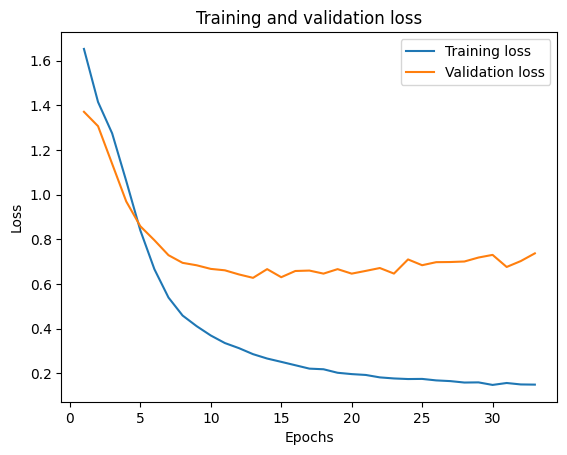

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

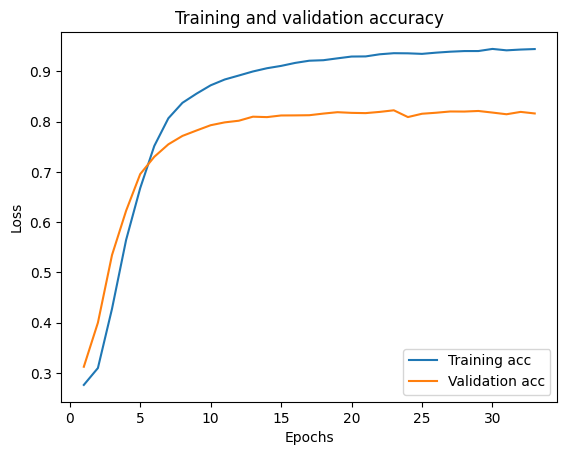

In [ ]:

plt.clf()   
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [60]:
model.evaluate(x_test,y_test)

467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8197 - loss: 0.7259


[0.7091693878173828, 0.8221195936203003]

In [61]:
model.evaluate(x_train,y_train)

1868/1868 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9552 - loss: 0.1167


[0.22958338260650635, 0.9299523234367371]

In [62]:
y_pred = model.predict(x_test).argmax(axis=-1)

467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


In [63]:
from sklearn.metrics  import classification_report ,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [64]:
report = classification_report(y_test, y_pred, target_names=classes_lb)
print(report)

              precision    recall  f1-score   support

  Irrelevant       0.84      0.75      0.80      2592
    Negative       0.83      0.87      0.85      4519
     Neutral       0.83      0.79      0.81      3596
    Positive       0.80      0.84      0.82      4230

    accuracy                           0.82     14937
   macro avg       0.82      0.81      0.82     14937
weighted avg       0.82      0.82      0.82     14937



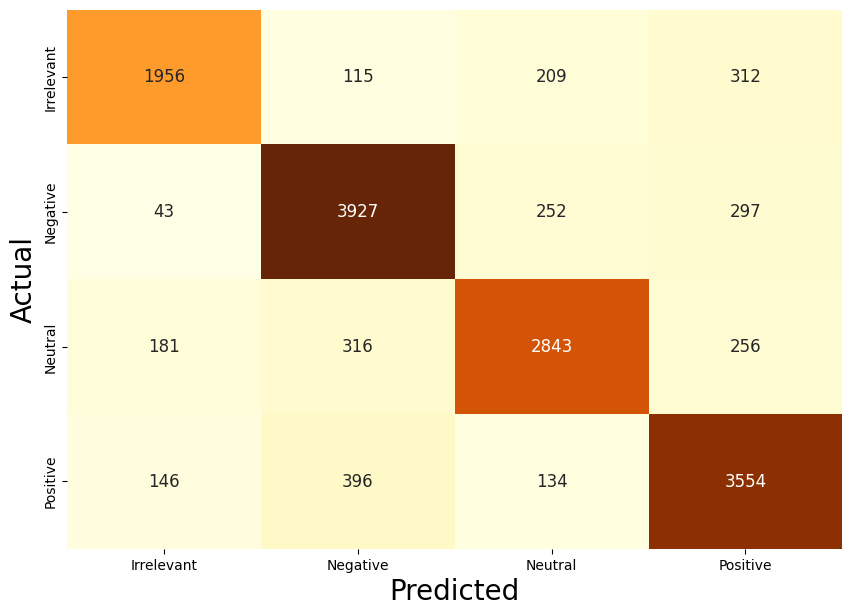

In [65]:
disp = confusion_matrix(y_test, y_pred)
disp.astype('int')
df_cm = pd.DataFrame(disp, classes_lb, classes_lb)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size":12},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.show()

LSTM****

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

embedding_size = 1000

model = Sequential()
model.add(Embedding(vocab_sz + 1, embedding_size, mask_zero=True, input_length=maxlen))

model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2)) 
model.add(Dropout(0.3)) 

model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))  
model.add(BatchNormalization())
model.add(Dropout(0.3))  

model.add(Dense(n_classes, activation='softmax'))  

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

callbacks_lst = [checkpoint]

batch_size = 256
epochs = 100
print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=callbacks_lst)



Train...
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100001000 elements. This may consume a large amount of memory.
  warnings.warn(


187/187 ━━━━━━━━━━━━━━━━━━━━ 133s 632ms/step - accuracy: 0.4817 - loss: 1.1686 - val_accuracy: 0.6250 - val_loss: 1.1670
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 632ms/step - accuracy: 0.8101 - loss: 0.5292 - val_accuracy: 0.7952 - val_loss: 0.6461
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 632ms/step - accuracy: 0.8815 - loss: 0.3304 - val_accuracy: 0.8258 - val_loss: 0.4702
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.9104 - loss: 0.2469 - val_accuracy: 0.8356 - val_loss: 0.4970
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.9215 - loss: 0.2102 - val_accuracy: 0.8360 - val_loss: 0.5282
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 630ms/step - accuracy: 0.9301 - loss: 0.1858 - val_accuracy: 0.8412 - val_loss: 0.5527
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 630ms/step - accuracy: 0.9338 - loss: 0.1742 - val_accuracy: 0.8501 - val_loss: 0.5122
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 118s 629ms/step - accuracy: 0.9378 - los

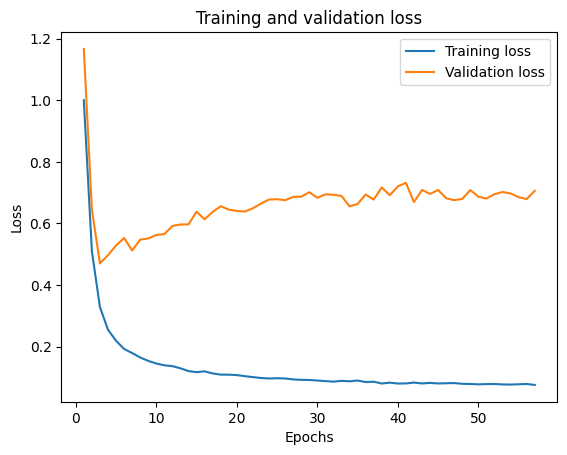

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

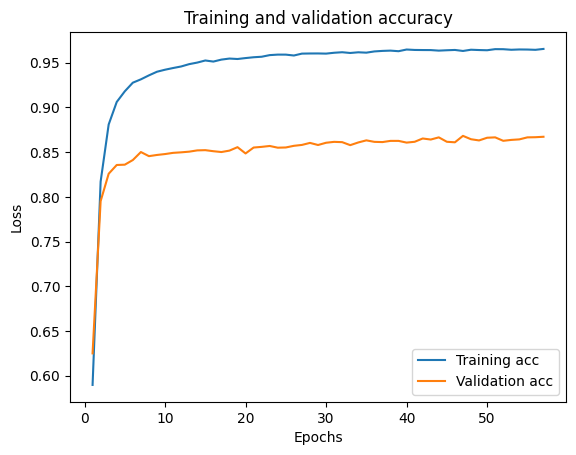

In [ ]:

plt.clf()   
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [70]:
model.evaluate(x_test,y_test)

467/467 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.8626 - loss: 0.6949


[0.6773294806480408, 0.8683136105537415]

In [71]:
model.evaluate(x_train,y_train)


1868/1868 ━━━━━━━━━━━━━━━━━━━━ 179s 96ms/step - accuracy: 0.9652 - loss: 0.0804


[0.1935236155986786, 0.9480625987052917]

In [72]:
y_pred = model.predict(x_test).argmax(axis=-1)


467/467 ━━━━━━━━━━━━━━━━━━━━ 46s 97ms/step


In [73]:
from sklearn.metrics  import classification_report ,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(y_test, y_pred, target_names=classes_lb)
print(report)


              precision    recall  f1-score   support

  Irrelevant       0.88      0.82      0.85      2592
    Negative       0.89      0.90      0.89      4519
     Neutral       0.88      0.84      0.86      3596
    Positive       0.83      0.89      0.86      4230

    accuracy                           0.87     14937
   macro avg       0.87      0.86      0.87     14937
weighted avg       0.87      0.87      0.87     14937



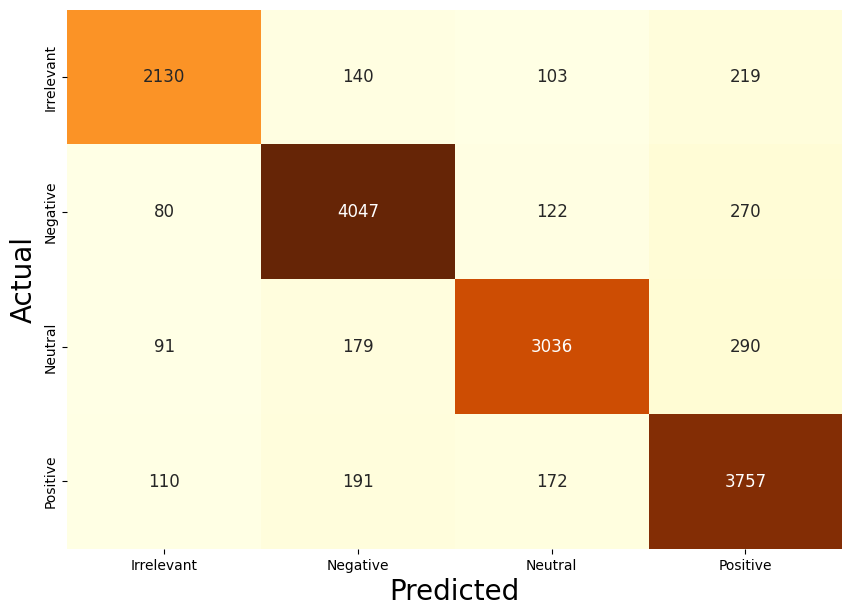

In [74]:
disp = confusion_matrix(y_test, y_pred)
disp.astype('int')
df_cm = pd.DataFrame(disp, classes_lb, classes_lb)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=True, annot_kws={"size":12},ax=ax, cmap="YlOrBr", fmt='g',cbar=False) #font
plt.ylabel('Actual',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
plt.show()